## **Hybrid Force Position Control**

In [1]:
from IPython.display import display, Javascript, SVG
import pydot


import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt, mpld3

from pydrake.all import (
    DiagramBuilder, ConnectPlanarSceneGraphVisualizer, Simulator, RigidTransform, LeafSystem, BasicVector,
    JacobianWrtVariable, RollPitchYaw, VectorLogSink, SpatialInertia, UnitInertia, Box, CoulombFriction
)
from pydrake.examples.manipulation_station import ManipulationStation

from manipulation import running_as_notebook
if running_as_notebook:
  mpld3.enable_notebook()


class TorqueController(LeafSystem):
  """Wrapper System for Commanding Pure Torques to planar iiwa.
    @param plant MultibodyPlant of the simulated plant.
    @param ctrl_fun function object to implement torque control law.
    @param vx Velocity towards the linear direction. 
  """
  def __init__(self, plant, ctrl_fun, vx):
    LeafSystem.__init__(self)
    self._plant = plant 
    self._plant_context = plant.CreateDefaultContext() 
    self._iiwa = plant.GetModelInstanceByName("iiwa")
    self._G = plant.GetBodyByName("body").body_frame()
    self._W = plant.world_frame()
    self._ctrl_fun = ctrl_fun 
    self._vx = vx

    self.DeclareVectorInputPort("iiwa_position_measured", BasicVector(3))
    self.DeclareVectorInputPort("iiwa_velocity_measured", BasicVector(3))

    # If we want, we can add this in to do closed-loop force control on z.
    #self.DeclareVectorInputPort("iiwa_torque_external", BasicVector(3))

    self.DeclareVectorOutputPort("iiwa_position_command", BasicVector(3),
                                 self.CalcPositionOutput)
    self.DeclareVectorOutputPort("iiwa_torque_cmd", BasicVector(3),
                                 self.CalcTorqueOutput)
    # Compute foward kinematics so we can log the wsg position for grading. 
    self.DeclareVectorOutputPort("wsg_position", BasicVector(3),
                                 self.CalcWsgPositionOutput)
    
  def CalcPositionOutput(self, context, output):
    """Set q_d = q_now. This ensures the iiwa goes into pure torque mode in sim by setting the 
    position control torques in InverseDynamicsController to zero. 
    NOTE(terry-suh): Do not use this method on hardware or deploy this notebook on hardware. 
    We can only simulate pure torque control mode for iiwa on sim. 
    """
    q_now = self.get_input_port(0).Eval(context)
    output.SetFromVector(q_now)

  def CalcTorqueOutput(self, context, output):    
    # Hard-coded position and force profiles. Can be connected from Trajectory class. 
    if (context.get_time() < 2.0):
      px_des = 0.65
    else:
      px_des = 0.65 + self._vx * (context.get_time() - 2.0)

    fz_des = 10 

    # Read inputs 
    q_now = self.get_input_port(0).Eval(context)
    v_now = self.get_input_port(1).Eval(context)
    #tau_now = self.get_input_port(2).Eval(context) 

    self._plant.SetPositions(self._plant_context, self._iiwa, q_now)

    # 1. Convert joint space quantities to Cartesian quantities.
    X_now = self._plant.CalcRelativeTransform(self._plant_context, self._W, self._G)

    rpy_now = RollPitchYaw(X_now.rotation()).vector()
    p_xyz_now = X_now.translation()

    J_G = self._plant.CalcJacobianSpatialVelocity(
        self._plant_context, JacobianWrtVariable.kQDot, 
        self._G, [0,0,0], self._W, self._W)
    
    # Only select relevant terms. We end up with J_G of shape (3,3). 
    # Rows correspond to (pitch, x, z).
    # Columns correspond to (q0, q1, q2). 
    J_G = J_G[(1,3,5),7:10]
    v_pxz_now = J_G.dot(v_now)

    p_pxz_now = np.array([rpy_now[1], p_xyz_now[0], p_xyz_now[2]])

    # 2. Apply ctrl_fun 
    F_pxz = self._ctrl_fun(p_pxz_now, v_pxz_now, px_des, fz_des)

    # 3. Convert back to joint coordinates
    tau_cmd = J_G.T.dot(F_pxz)
    output.SetFromVector(tau_cmd)

  def CalcWsgPositionOutput(self, context, output):
    """
    Compute Forward kinematics. Needed to log the position trajectory for grading.
    """
    q_now = self.get_input_port(0).Eval(context)
    self._plant.SetPositions(self._plant_context, self._iiwa, q_now)
    X_now = self._plant.CalcRelativeTransform(self._plant_context, self._W, self._G)

    rpy_now = RollPitchYaw(X_now.rotation()).vector()
    p_xyz_now = X_now.translation()
    p_pxz_now = np.array([rpy_now[1], p_xyz_now[0], p_xyz_now[2]])

    output.SetFromVector(p_pxz_now)

def AddBook(plant):
  mu = 10.0
  book = plant.AddModelInstance("book")
  book_body = plant.AddRigidBody("book_body", book, 
                                 SpatialInertia(
                                     mass = 0.2, 
                                     p_PScm_E=np.array([0., 0., 0.]),
                                     G_SP_E = UnitInertia(1.0, 1.0, 1.0)))
  shape = Box(0.3, 0.1, 0.05)
  if plant.geometry_source_is_registered():
    plant.RegisterCollisionGeometry(book_body, RigidTransform(), shape, "book_body", CoulombFriction(mu, mu))
    plant.RegisterVisualGeometry(book_body, RigidTransform(), shape, "book_body", [.9, .2, .2, 1.0])

  return book 

def BuildAndSimulate(ctrl_fun, velocity, duration):
  builder = DiagramBuilder()

  # Add ManipulationStation 
  station = builder.AddSystem(ManipulationStation(time_step = 1e-3))
  station.SetupPlanarIiwaStation()
  book = AddBook(station.get_mutable_multibody_plant())

  station.Finalize()

  controller = builder.AddSystem(
      TorqueController(station.get_multibody_plant(), ctrl_fun, velocity))
  
  logger = builder.AddSystem(VectorLogSink(3))

  builder.Connect(controller.get_output_port(0),
                  station.GetInputPort("iiwa_position"))
  builder.Connect(controller.get_output_port(1),
                  station.GetInputPort("iiwa_feedforward_torque"))
  builder.Connect(controller.get_output_port(2),
                  logger.get_input_port(0))
  
  builder.Connect(station.GetOutputPort("iiwa_position_measured"),
                  controller.get_input_port(0))
  builder.Connect(station.GetOutputPort("iiwa_velocity_estimated"),
                  controller.get_input_port(1))

  if running_as_notebook:
      vis = ConnectPlanarSceneGraphVisualizer(
          builder,
          station.get_scene_graph(),
          output_port=station.GetOutputPort("query_object"),
          xlim=[-0.5, 1.2],
          ylim=[-0.8, 2],
          show=False)
  
  diagram = builder.Build()
  display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

  # Initialize default positions for plant. 
  plant = station.get_mutable_multibody_plant()
  simulator = Simulator(diagram)
  plant_context = plant.GetMyContextFromRoot(simulator.get_mutable_context())
  plant.SetFreeBodyPose(plant_context, 
                        plant.GetBodyByName("book_body"),
                        RigidTransform([0.65, 0.0, 0.03])) # limit is between 0.5 and 0.55
  plant.SetPositions(plant_context, 
                     plant.GetModelInstanceByName("iiwa"),
                     np.array([np.pi/4, -np.pi/3, np.pi/3]))
  
  station_context = station.GetMyContextFromRoot(simulator.get_mutable_context())
  station.GetInputPort("wsg_position").FixValue(station_context, [0.02])

  if running_as_notebook:
    vis.start_recording()
    simulator.AdvanceTo(duration)
    vis.stop_recording()

    ani = vis.get_recording_as_animation(repeat=False)
    display(HTML(ani.to_jshtml()))
    
  else:
    # TODO(terry-suh): we need to simulate this fully to grade student's answers, but CI won't be happy.
    simulator.AdvanceTo(duration)

  pose = plant.GetFreeBodyPose(plant_context,
                               plant.GetBodyByName("book_body"))
  
  # Return these so that we can check the pose of each object. 
  return logger.FindLog(simulator.get_context()), plant, plant_context


# Book Dragging

In the lecture, we've written a controller that does non-prehensile manipulation by flipping a cheez-it box using external contacts. In this example, we will examine another example of non-prehensile manipulation that relies on pushing with friction. 

We have seen a wonderful example of non-prehensile manipulation on this example during [lecture](https://slides.com/russtedrake/fall20-lec12#/4). 

[![Jiaji_book_pushing](http://img.youtube.com/vi/PngdQGEUi7w/0.jpg)](http://www.youtube.com/watch?v=PngdQGEUi7w "Video Title")


Throughout this notebook, we will implement a hybrid force-position controller to achieve this dragging motion. 


# Analysis of Frictional Forces

Let's take some time to first think about the physics of what is going on. What causes the book to move when we drag it with some downwards force? This particular example is interesting because how much we rely on friction. If we were to draw a rough diagram of forces, we would end up with the below figure. Note that we've summarized the interaction forces with the book and the ground with a point contact model, but the story can be more complicated.  

<img src="https://raw.githubusercontent.com/RussTedrake/manipulation/master/figures/exercises/friction.png" width="700">

In class we saw the Coulomb model of friction, where the frictional forces must lie inside the friction cone that relates the normal force:
$$|f_x| \leq \mu f_z$$

where $\mu$ is the static coefficient of friction. 

**Problem 7.3.a** [3pts]: Under the Coloumb friction model, write down the conditions for the ratio of friction coefficients $\mu^C/\mu^A$ that enables us to drag the book, as a function of $m,g$, and $f^C_{C_z}$ (HINT: don't forget about gravity!)  


**Problem 7.3.b** [1pts] Based on the answer to 7.3.a, do you agree with the following statement? 

**Using a smoother surface on the gripper (lower $\mu^C$) will make this motion more feasible.**

Why or why not? 

**Problem 7.3.c** [1pts] Based on the answer to 7.3.a, do you agree with the following statement? 

**Pressing down harder (higher $N$) will make this motion more feasible**. 

Why or why not?

# Hybrid Force-Position Control 

How should we write this type of a controller? We know how to do position control, and we know how to do force control, and we know it's hard to do both. But this task seems to require both. Namely, 

- We want to achieve desired position along the x-direction. 
- We want to achieve desired force along the z-direction. 

The key idea of hybrid force/position control is that when the force-controlled directions and the position-controlled directions are orthonormal, it is possible to control both in different directions! 

NOTE: We will do an axis-aligned version of orthonormal forces here, but with a bit more math, the rich theory of linear algebra allows us to generalize to arbitrary orthonormal planes as well. 

#### **Problem 7.3.d** [4pts] Below, you will write a function `compute_ctrl` that implements a feedback policy which computes spatial forces $u=[\tau_y,f_x,f_z]$ upon given current and desired position along the $x,\theta_y$ direction, while achieving desired forces along the $z$ direction. 

You can implement each direction independently as follows:
- Implement a PD controller in x-direction which drives `x_now` to `x_des`. You are free to set and tune the gains. 
- Implement a PD controller in $\theta_y$-direction which drives `theta_now` to 0. 
- Implement an open-loop force controller in the $z$-direction which applies forces along the z-direction, such that `f_des` is the force applied on the book. 

NOTE: If we had a point finger, we wouldn't have had to regulate `theta_now` at all - but why was this necessary for the rigid-body gripper? After implementing everything, try setting only tau_y (`u[0]`) to zero and see what happens! 

In [2]:
def compute_ctrl(p_pxz_now, v_pxz_now, x_des, f_des):
  """Compute control action given current position and velocities, as well as 
  desired x-direction position p_des(t) / desired z-direction force f_des. 
  You may set theta_des yourself, though we recommend regulating it to zero. 
  Input:
    - p_pxz_now: np.array (dim 3), position of the finger. [thetay, px, pz] 
    - v_pxz_now: np.array (dim 3), velocity of the finger. [wy, vx, vz] 
    - x_des: float, desired position of the finger along the x-direction. 
    - f_des: float, desired force on the book along the z-direction. 
  Output:
    - u    : np.array (dim 3), spatial torques to send to the manipulator. [tau_y, fx, fz] 
  """
  Kp_x = 30
  Kd_x = 25

  Kp_y = 10
  Kd_y = 5

  thetay, px, pz = p_pxz_now
  wy, vx, vz = v_pxz_now

  # PD controller x-dir
  fx = Kp_x * (x_des - px) - Kd_x * vx

  # PD controller theta-y
  tau_y = Kp_y * (0 - thetay) - Kd_y * wy

  # Open-loop controller z-dir
  fz = -f_des

  # print("Positions")
  # print([thetay, px])

  # print("Deltas")
  # print([wy, vx])

  # print("Desired")
  # print(f_des, x_des)

  u = np.array([tau_y, fx, 0])
  # u = np.array([tau_y, fx, fz])
  # u = np.array([0, 0, fz])
  return u

You can run the below cell to check your implementation. Using your controller, we will be tracking a linear position trajectory in the $x$-direction specified as:

`x_des(t) = 0.65 + velocity * max(t - 2.0, 0.0)`

In the below cell, you are free to set the velocity, and the $t_f$ (the end time of the trajectory). For grading, we will be checking for the following:

- At the end of the time, the left edge of the book lies between the gap of the two tables. 
- At each timestep, the gripper fingers stays above the book. (we specifically want you to drag the book, so pushing it from the side is not allowed).  

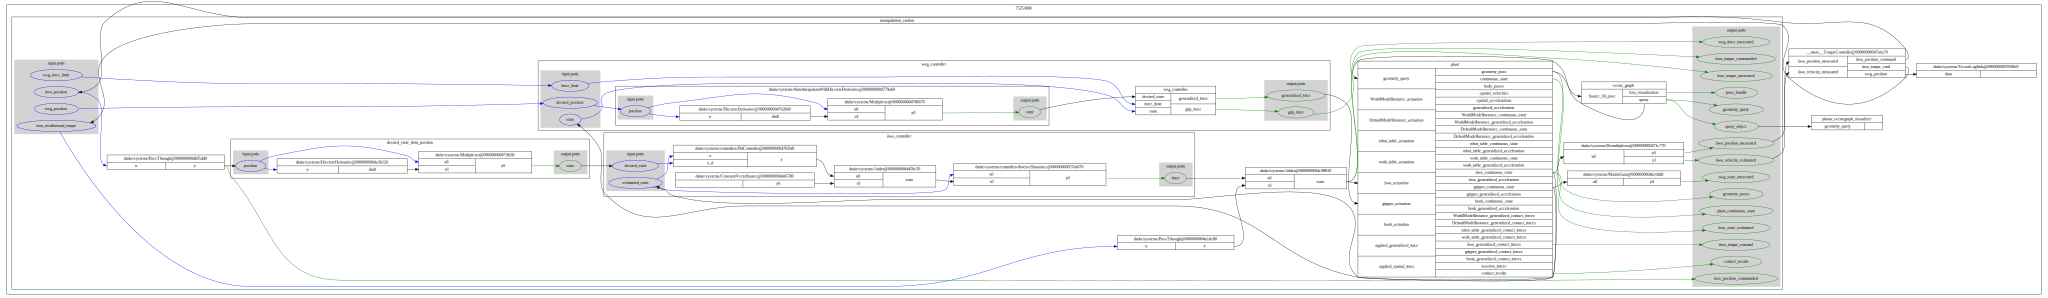

In [3]:
# NOTE: you may tune the velocity and duration to achieve the above specification. 
velocity = -0.125  # p_des = 0.65 + velocity * max\{time - 2.0, 0\}
duration = 10     # duration to simulate. We check the book pose at the end of duration. set to 5~10.
log, plant, plant_context = BuildAndSimulate(compute_ctrl, velocity, duration)

## How will this notebook be Graded?

If you are enrolled in the class, this notebook will be graded using [Gradescope](www.gradescope.com). You should have gotten the enrollement code on our announcement in Piazza. 

For submission of this assignment, you must do two things. 
- Download and submit the notebook `hybrid_force_position.ipynb` to Gradescope.
- Write down your answers to 7.3.a, 7.3.b, and 7.3.c in your PDF submission to Gradescope. 

We will evaluate the local functions in the notebook to see if the function behaves as we have expected. For this exercise, the rubric is as follows:
- [3 pts] 7.3.a is answered correctly.
- [1 pts] 7.3.b is answered correctly. 
- [1 pts] 7.3.c is answered correctly.
- [4 pts] `compute_ctrl` must be implemented correctly.


In [4]:
from manipulation.exercises.force.test_hybrid import TestHybrid
from manipulation.exercises.grader import Grader 

Grader.grade_output([TestHybrid], [locals()], 'results.json')
Grader.print_test_results('results.json')

Total score is 0/4.

Score for Test compute_ctrl is 0/4.
- Test Failed: 0.6499997473062213 not less than or equal to 0.55 : Edge of the book is not between the gap. It is too far.



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8370ebb5-7687-438c-9df6-6340716a9ec8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>